__This Dataset has been downloaded from the kaggle.__

The Dataset is fully dedicated for the developers who want to train the model on Weather Forecasting for Indian climate. This dataset provides data from 1st January 2013 to 24th April 2017 in the city of Delhi, India. The 4 parameters here are
meantemp, humidity, wind_speed, meanpressure.

    meantemp :- Mean temperature averaged out from multiple 3 hour intervals in a day.
    himidity :- Humidity value for the day (units are grams of water vapor per cubic meter volume of air).
    wind_speed :- Wind speed measured in kmph.
    meanpressure :- Pressure reading of weather (measure in atm)

# Time Series Analyisis

[Importing required libraries](#Importing-required-libraries)

[Importing Dataset](#Importing-Dataset)

[Memory Management function](#Memory-Management-function)


1. [Feature Engineering](#Feature-Engineering)
 - [check and handle missing value](#Missing-Value)
 - [checking and changing the frequency of the data(Resampling(Upsampling and downsampling))](#Resampling)
 - [performing Exploratory Data Analysis(EDA)](#Exploratory-Data-Analysis)
 - [Time Series Decomposition](#Time-Series-Decomposition)
     - trend
     - seasonality
     - residue
   (I will be performing  [Moving Average](#Smoothing-Curve) for looking the trend by smoothing the curve, Also I will be           computing the anomaly using the confidence interval)
  - [Compare the different time series data(for example:- meantemp vs humity, meantemp vs humidity vs meanpressure)](#Compare-the-different-time-series)
  - [Normalized the data before comparing the time series](#Normalization)
  - [Stationarity check (Augmented Dicky-Fuller Test)](#Augmented-Dicky-Fuller-Test)
  - [Plotting AutoCorrelation Function(ACF) and Partial AutoCorrelation Function(PACF)](#ACF-and-PACF)
        
2. [Model Creation](#Model-Creation)
 - [AR model](#AR-model)
 - [ARMA model](#ARMA-model)
 - [ARIMA model](#ARIMA model)
 - [SARIMA model](#SARIMA model)
    (I will be using [pmdarima](#pmdarima) also to perform auto_arima which gives us the best arima model based on the aic value)
        
3. [Model Validation](#Model-Validation)
 - [Predicting the test dataset](#Predicting-the-test-dataset)
 - [Cross Validation](#Cross-Validation)
 - [Performance Measures](#Performance-Measures):-  Mean square error, Root mean square error, Rsquare, Mean Avsolute error, Median Absolute Error, Mean Squared Logarithmic Error, Mean Absolute Percentage Error
        
4. [Saving the model](#Saving-the-model)
 -  [using pickle](#pickle)
 - [using joblib](#joblib)
 - [using parquet](#parquet)
 
       [(Difference between pickle, joblib and parquet)](#Difference-between-pickle,-joblib-and-parquet)
         
5. [Loading the model and predicting the future](#Loading-the-model-and-predicting-the-future)

# Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm 
from scipy.optimize import minimize  

from pmdarima import auto_arima
from tqdm import tqdm_notebook
from itertools import product            # some useful functions

import warnings                          # to ignore the unnecessary warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf



# Importing Dataset

In [2]:
%%time
df = pd.read_csv('DailyDelhiClimateTrain.csv', index_col = 'date', parse_dates=True)
df

Wall time: 14 ms


meantemp    humidity  wind_speed  meanpressure
date                                                       
2013-01-01  10.000000   84.500000    0.000000   1015.666667
2013-01-02   7.400000   92.000000    2.980000   1017.800000
2013-01-03   7.166667   87.000000    4.633333   1018.666667
2013-01-04   8.666667   71.333333    1.233333   1017.166667
2013-01-05   6.000000   86.833333    3.700000   1016.500000
...               ...         ...         ...           ...
2016-12-28  17.217391   68.043478    3.547826   1015.565217
2016-12-29  15.238095   87.857143    6.000000   1016.904762
2016-12-30  14.095238   89.666667    6.266667   1017.904762
2016-12-31  15.052632   87.000000    7.325000   1016.100000
2017-01-01  10.000000  100.000000    0.000000   1016.000000

[1462 rows x 4 columns]

In the time series we need datatime format in the index so we have converted our date into date time format and parsed the date to use as the index column

##### Memory Management function
    while loading the data by using the pandas, all the feature that are of type int are converted into int64 and all the feature that are of type float are converted into float64 which we are mannually trying to lower down so that our project will consume less memory and executes fast.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In this case we have a small dataset so we may not notice the huge different but it is always better to appy this fuction to save the memory. Here we can see that all the columns are of float type and we can see each of them are float64. We can also see the memory usuage as 57.1 KB. so, let me apply the function to convert int64 or int 32 to int16 and float64 to float32.

In [4]:
def downcast_type(df):
    _start = df.memory_usage(deep=True).sum()/1024**2
    float_cols = [c for c in df if df[c].dtype == 'float64']
    int_cols = [c for c in df if df[c].dtype in ['int64','int32']]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    _end = df.memory_usage(deep = True).sum()/1024**2
    saved = (_start-_end)/_start*100
    print(saved)
    return df

In [5]:
df = downcast_type(df)

40.0


In [6]:
df.head() # top 5 values of the dataset

meantemp   humidity  wind_speed  meanpressure
date                                                      
2013-01-01  10.000000  84.500000    0.000000   1015.666687
2013-01-02   7.400000  92.000000    2.980000   1017.799988
2013-01-03   7.166667  87.000000    4.633333   1018.666687
2013-01-04   8.666667  71.333336    1.233333   1017.166687
2013-01-05   6.000000  86.833336    3.700000   1016.500000

In [7]:
df.tail() # buttom 5 records in the dataset

meantemp    humidity  wind_speed  meanpressure
date                                                       
2016-12-28  17.217392   68.043480    3.547826   1015.565247
2016-12-29  15.238095   87.857140    6.000000   1016.904785
2016-12-30  14.095238   89.666664    6.266667   1017.904785
2016-12-31  15.052631   87.000000    7.325000   1016.099976
2017-01-01  10.000000  100.000000    0.000000   1016.000000

In [8]:
df.columns # checking all the columns as mentioned in the information above

Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float32
 1   humidity      1462 non-null   float32
 2   wind_speed    1462 non-null   float32
 3   meanpressure  1462 non-null   float32
dtypes: float32(4)
memory usage: 34.3 KB


Here we can see that all the Dtypes has been converted to the float32 and memory usuage has been decreased by 40% so now the memory usuage is 34.3KB. It is extremly effective for the larger dataset.

In [10]:
# we can also save the file in the parquet format so that we can reduce the loading time of the file
# df.to_parquet('climate_data_training.parquet.gzip', compression = 'gzip')

In [11]:
# %%time
# df = pd.read_parquet('climate_data_training.parquet.gzip')

We can see the decrease of loading time when we import the dataset in the parquet format

# Feature Engineering

##### Missing Value

In [12]:
df.isnull().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

No, missing values

##### Resampling
> Resampling may play an important role in the time-series dataset because when we cannot predict or model the best model with the current frequency then we may need to change. We have two types of resampling as described as follow:-
   - __Upsampling__(increasing the frequency i.e. from 'M' to 'D')
       - it is performed in order to fill or interpolate missing values
   - __Downsampling__(decreasing the frequency i.e. from 'D' to 'M')
       - it is performed in order to aggregate the existing data

In [13]:
df.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
               '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30',
               '2016-12-31', '2017-01-01'],
              dtype='datetime64[ns]', name='date', length=1462, freq=None)

by using the dataset.index fuction we can see that frequency of the dataset is None, so let me difine it now that our dataset is on the Daily basis.

In [14]:
df = df.asfreq('D')

In [15]:
df.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
               '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30',
               '2016-12-31', '2017-01-01'],
              dtype='datetime64[ns]', name='date', length=1462, freq='D')

We can now see that the data is in the daily basis

###### Example of resampling types

In [16]:
# Downsampling
df_monthly = df.resample('M').mean() # M stads for the month
df_monthly.head()

meantemp   humidity  wind_speed  meanpressure
date                                                      
2013-01-31  12.074770  73.028801    4.833913   1017.847717
2013-02-28  16.867559  71.938560    7.474090   1015.945984
2013-03-31  22.814209  57.417244    8.757270   1011.733887
2013-04-30  28.895119  34.612103    8.046385   1006.292358
2013-05-31  33.776768  28.938250    8.943452    999.924194

In [17]:
df_monthly.index

DatetimeIndex(['2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31', '2013-11-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31'],
              dtype='datetime64[ns]', name='date', freq='M')

Now the frequency of data is Monthly and it mean value of the Month is taken.

In [18]:
# Upsampling 
df_Daily_from_Monthly = df_monthly.resample('D').pad()
df_Daily_from_Monthly

meantemp    humidity  wind_speed  meanpressure
date                                                       
2013-01-31  12.074770   73.028801    4.833913   1017.847717
2013-02-01  12.074770   73.028801    4.833913   1017.847717
2013-02-02  12.074770   73.028801    4.833913   1017.847717
2013-02-03  12.074770   73.028801    4.833913   1017.847717
2013-02-04  12.074770   73.028801    4.833913   1017.847717
...               ...         ...         ...           ...
2017-01-27  17.672565   68.840385    6.132705   1016.291016
2017-01-28  17.672565   68.840385    6.132705   1016.291016
2017-01-29  17.672565   68.840385    6.132705   1016.291016
2017-01-30  17.672565   68.840385    6.132705   1016.291016
2017-01-31  10.000000  100.000000    0.000000   1016.000000

[1462 rows x 4 columns]

In [19]:
df_Daily_from_Monthly.index

DatetimeIndex(['2013-01-31', '2013-02-01', '2013-02-02', '2013-02-03',
               '2013-02-04', '2013-02-05', '2013-02-06', '2013-02-07',
               '2013-02-08', '2013-02-09',
               ...
               '2017-01-22', '2017-01-23', '2017-01-24', '2017-01-25',
               '2017-01-26', '2017-01-27', '2017-01-28', '2017-01-29',
               '2017-01-30', '2017-01-31'],
              dtype='datetime64[ns]', name='date', length=1462, freq='D')

Here again the data is upsampled to the daily basis, but the disadvantage is that all the data in between are filled with the mean value.

##### Exploratory Data Analysis

Let up simple plot the dataframe first

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F24DE89EE0>,
      dtype=object)

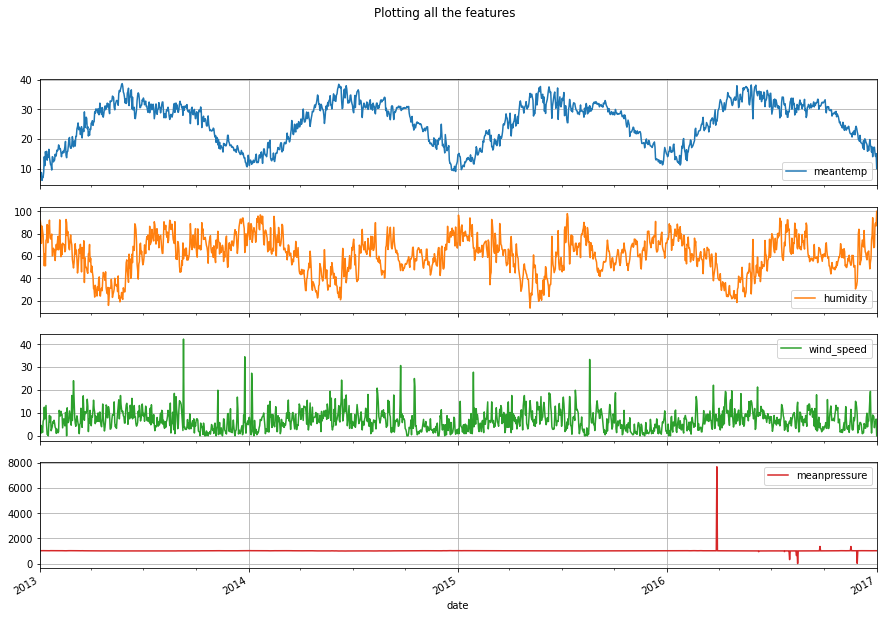

In [20]:
df.plot(subplots = True, grid = True, title = 'Plotting all the features', figsize = (15,10))

From the above figure we can see the pattern of data but we cannot find the trend and the seasonality of the dataset.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F24E7549D0>,
      dtype=object)

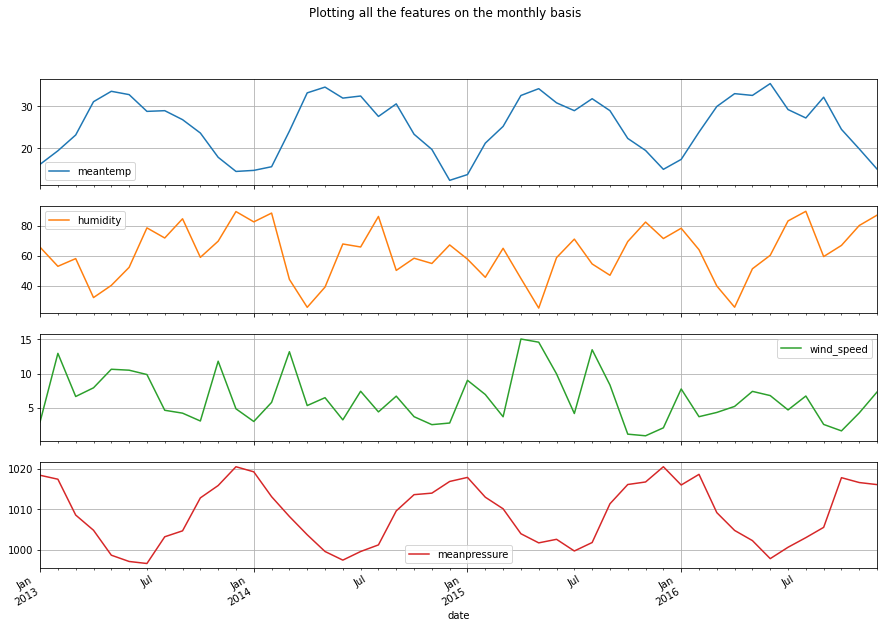

In [21]:
# let us see the dataset on the monthly basis
df.asfreq('M').plot(subplots = True, grid = True, title = 'Plotting all the features on the monthly basis', figsize = (15,10))

##### Time Series Decomposition
> Trends, seasonality, and noisy
  These are the components of a time series
   - __Trend__ : Consistent upwards or downwards slope of a time series
   - __Seasonality__ : Clear periodic pattern of a time series
   - __Noise__ : Outliers or missing values

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

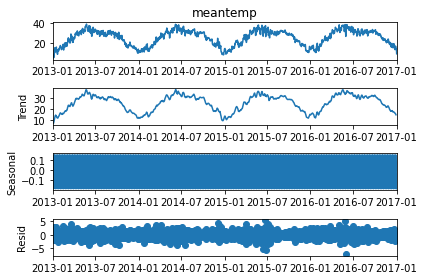

In [23]:
seasonal_decompose(df['meantemp']).plot()
plt.show()

It is difficult to read and understand so we will plot it individually as follow

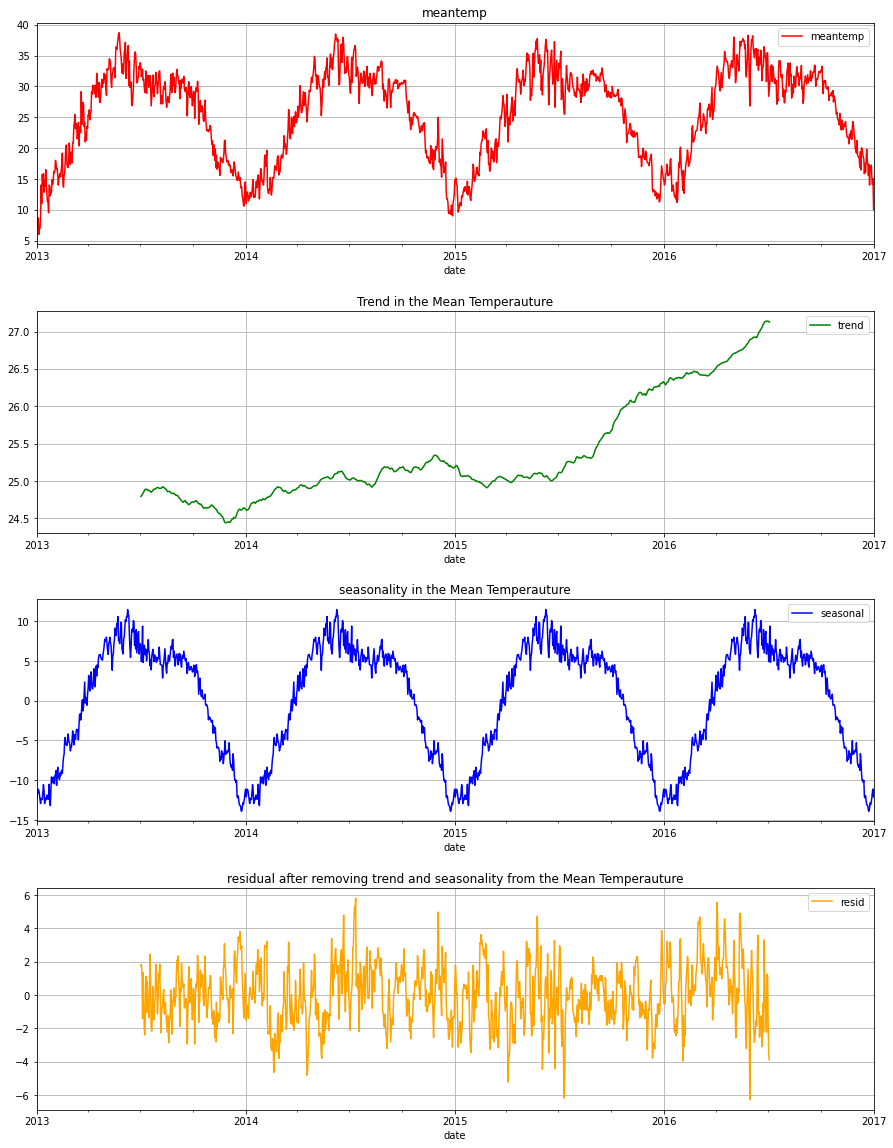

In [24]:
decomposed_mean_temperature_volume = sm.tsa.seasonal_decompose(df.meantemp, freq = 365) # setting the freqency as 365 inorder to see the seasonality clearly. from the original plot we can see that the data have a seasonality of a year
fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,1,figsize = (15,20))
df.meantemp.plot(ax = ax0,title='meantemp',color='r',grid = True, legend = True)
decomposed_mean_temperature_volume.trend.plot(ax = ax1,title='Trend in the Mean Temperauture',color='g',grid = True, legend = True)
decomposed_mean_temperature_volume.seasonal.plot(ax = ax2,title='seasonality in the Mean Temperauture',color='b',grid = True, legend = True)
decomposed_mean_temperature_volume.resid.plot(ax = ax3,title='residual after removing trend and seasonality from the Mean Temperauture',color='orange',grid = True, legend = True)
plt.subplots_adjust(hspace = 0.3)
plt.show()

from the above result,
- there is clearly an upward trend, which is difficult to observe from the original graph.
- we can see the uniform season change.
- Non-uniform noise that represent outliers and missing values

##### Smoothing Curve

There are different ways to smooth the curve and this methods are used to predict the future. Some of the smoothing techniques are Moving Average, Exponential Smoothing, Double Exponential Smoothing, Triple Exponential Smoothing which is also called as Holt-Winters. Moving Average is used to predict one value in the future, where as Exponential is also used to predict 1 value but it assigs the weight to its lags so that the newest lag has more impact on the prediction or forecast. Double Exponential is used to forecast more than the one day in the future and it is similar to the exponential but the new term like change in weight is taken into consideration to know the change in direction of the trend. Finally Triple Exponential is same as double but it has an additional component seasonality so it is applied for the seasonal dataset.

For the simplecity, I will be just play with Moving Average for the Practise and knowledge since we are more focused on the ARIMA family in this project.

#### Moving Average
>  we will use windows rolling concept for the moving average and smoothing the graph

>  we will be using absolute mean error for calculating upper and lower bounds

__Window functions__
> Window functions are used to identify sub periods, calculates sub-metrics of sub-periods.
   - Rolling : Same size and sliding
   - Expanding : Contains all prior values. 
   
> one example for each is as follow

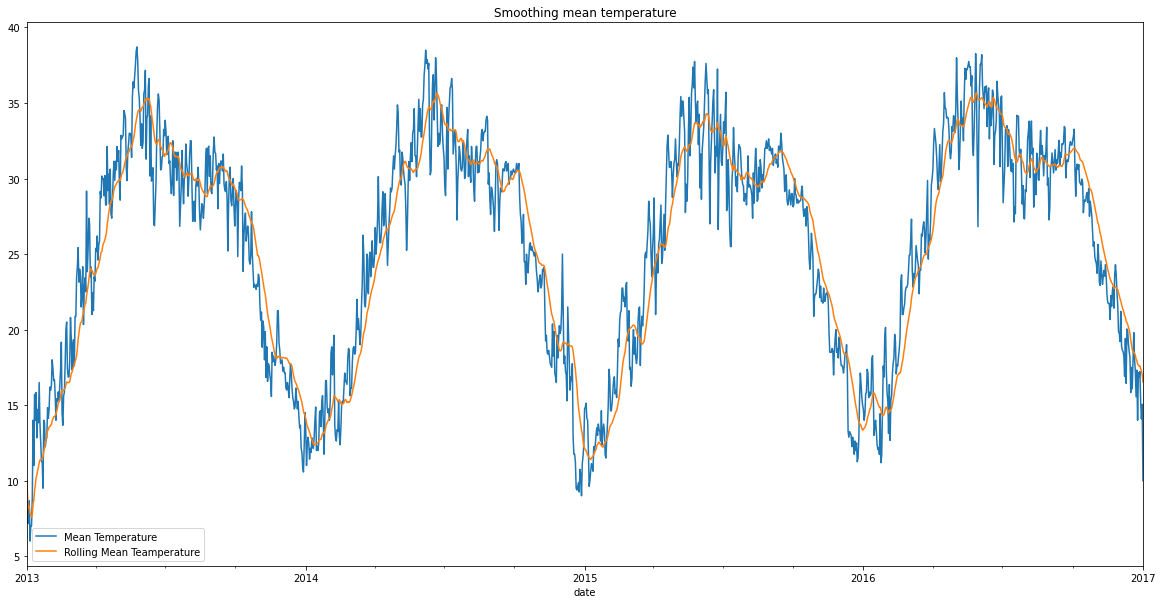

In [25]:
# rolling windows acts as a smoothing function in many cases
rolling_meantemp = df.meantemp.rolling('20D').mean()
df.meantemp.plot(figsize=(20,10),legend = True)
rolling_meantemp.plot(legend = True)
plt.legend(['Mean Temperature','Rolling Mean Teamperature'])
plt.title('Smoothing mean temperature')
plt.show()

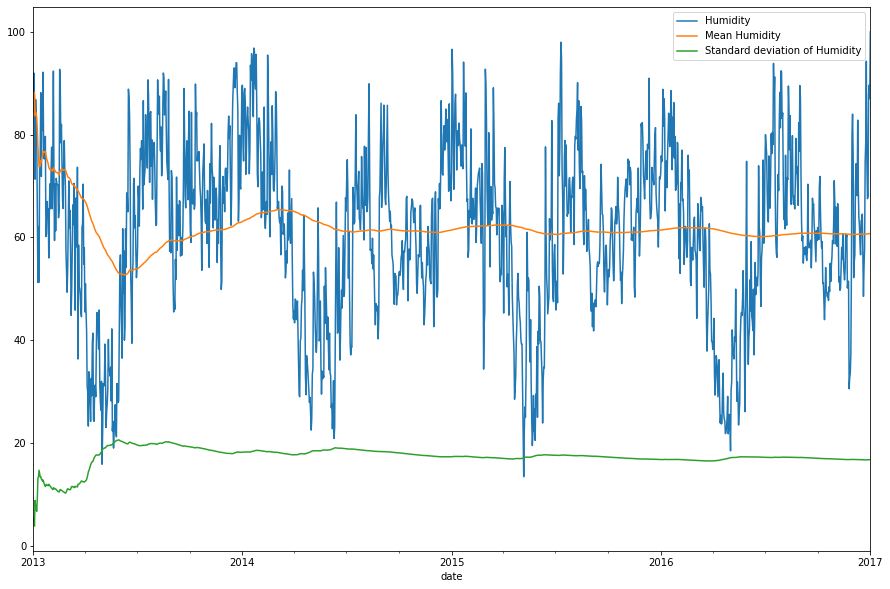

In [26]:
#expanding keeps on increasing the input and caluculates the mean or std of that
mean_humidity = df.humidity.expanding().mean()
std_humidity = df.humidity.expanding().std()

df.humidity.plot(figsize =(15,10))
mean_humidity.plot()
std_humidity.plot()
plt.legend(['Humidity','Mean Humidity','Standard deviation of Humidity'])
plt.show()

Let us define fuction for plotting the Moving Average

In [27]:
def plot_moving_average(series, windows , feature_name, scale = 1.96, plot_anomalies = False, plot_intervals = False):
    series = pd.DataFrame(series)
    rolling_mean = series.rolling(window = windows).mean()
    
    plt.figure(figsize = (15,5))
    plt.title('Moving Average of {} \n Windows size = {}'.format(feature_name,windows))
    plt.plot(rolling_mean, 'red', label = 'Rolling mean trend')
    
    #for ploting the upper and lower bound
    if plot_intervals == True:
        mae = mean_absolute_error(series[windows:],rolling_mean[windows:])
        deviation = np.std(series[windows:]-rolling_mean[windows:])
        lower_bound = rolling_mean-(mae+scale*deviation)
        upper_bound = rolling_mean+(mae+scale*deviation)
        plt.plot(upper_bound,'g--', label = 'Upper Bound/ Lower Bound')
        plt.plot(lower_bound,'g--')
    
    # for pointing the anomaly in the dataset
    if plot_anomalies == True:
        anomaly = pd.DataFrame(index = series.index, columns=df.columns)
        anomaly[series<lower_bound] = series[series<lower_bound]
        anomaly[series>upper_bound] = series[series> upper_bound]
        plt.plot(anomaly, 'ro', markersize = 10, label = 'Anomaly')
        
    plt.plot(series[windows:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
        

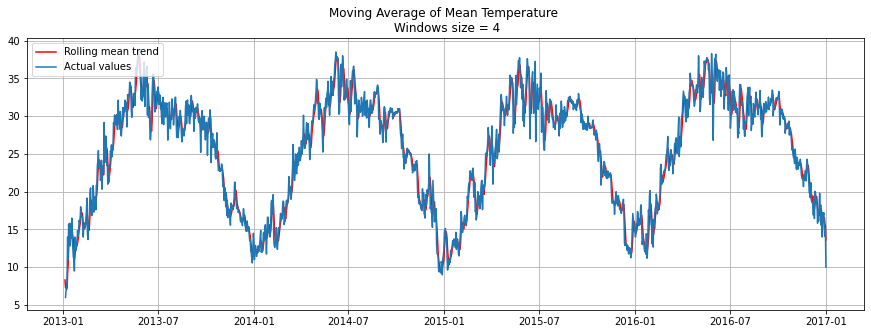

In [28]:
plot_moving_average(df.meantemp, 4, 'Mean Temperature')

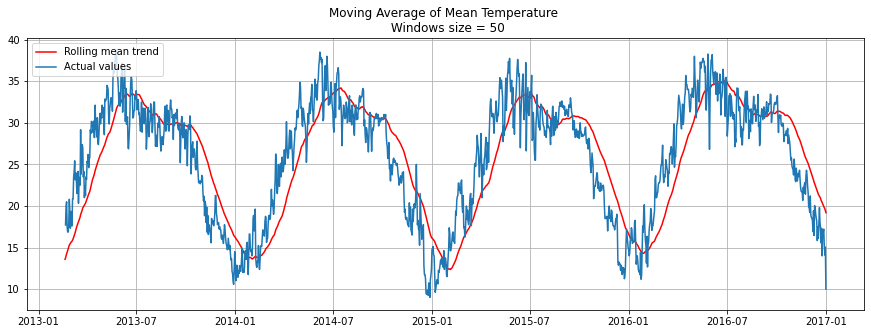

In [29]:
plot_moving_average(df.meantemp,50, 'Mean Temperature')

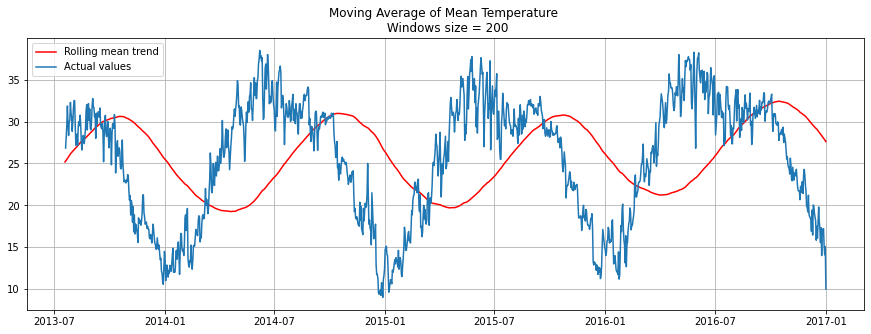

In [30]:
plot_moving_average(df.meantemp,200, 'Mean Temperature')

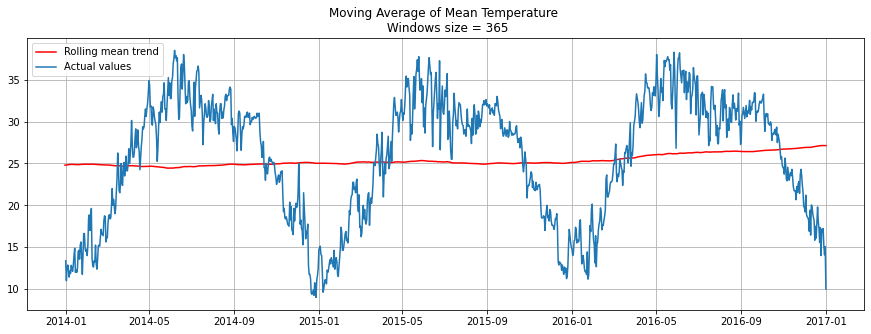

In [31]:
plot_moving_average(df.meantemp, 365, 'Mean Temperature')

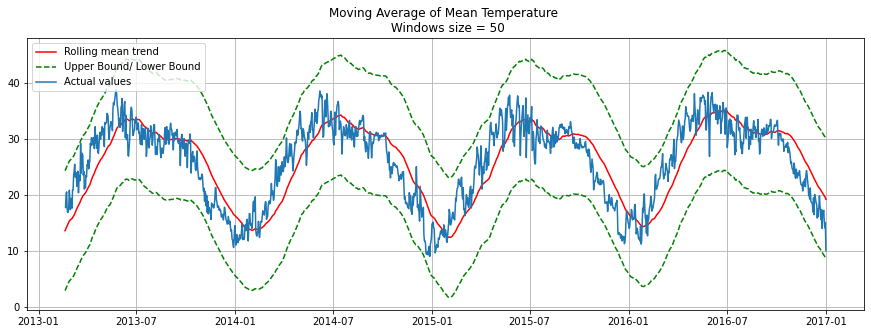

In [32]:
plot_moving_average(df.meantemp, 50 , 'Mean Temperature', plot_intervals=True)

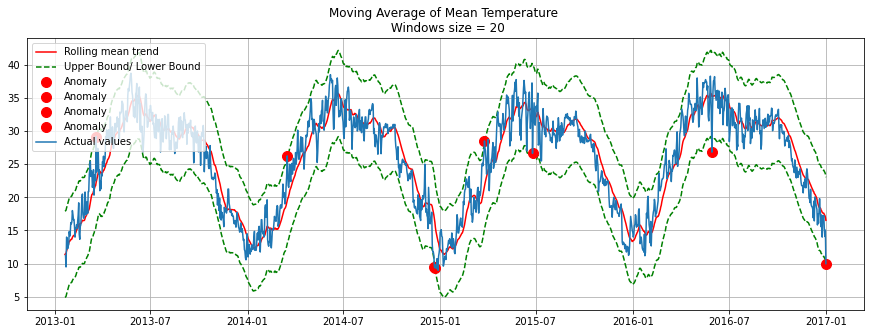

In [33]:
plot_moving_average(df.meantemp, 20 , 'Mean Temperature', plot_intervals=True, plot_anomalies=True)

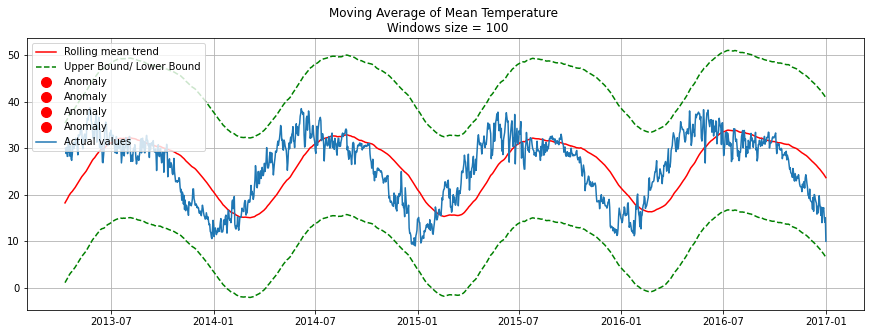

In [34]:
plot_moving_average(df.meantemp, 100 , 'Mean Temperature', plot_intervals=True, plot_anomalies=True)

We can see how the rolling mean change with the windows size. We also saw that higher the windows size smoother the series is. We can also see the anomalies in the dataset and also notice that how the change in windows size has an effec on the anomaly detection.

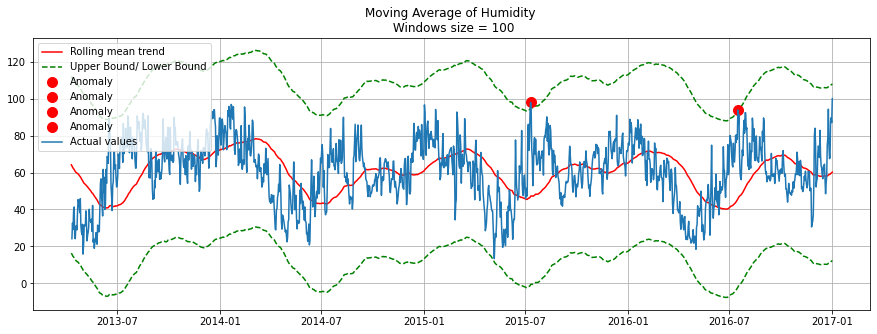

In [35]:
plot_moving_average(df.humidity, 100 ,'Humidity', plot_intervals=True, plot_anomalies=True)

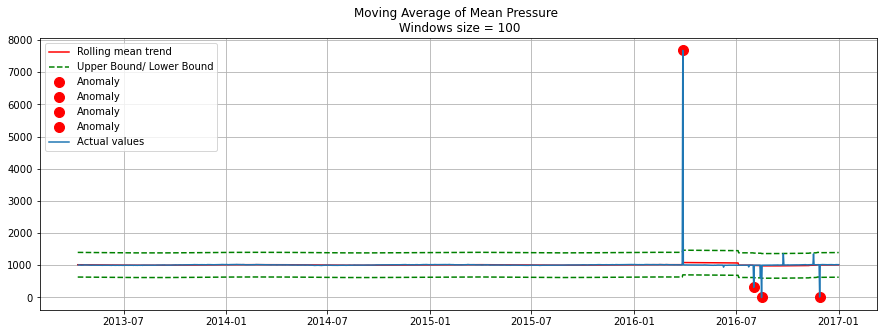

In [36]:
plot_moving_average(df.meanpressure, 100 ,'Mean Pressure', plot_intervals=True, plot_anomalies=True)

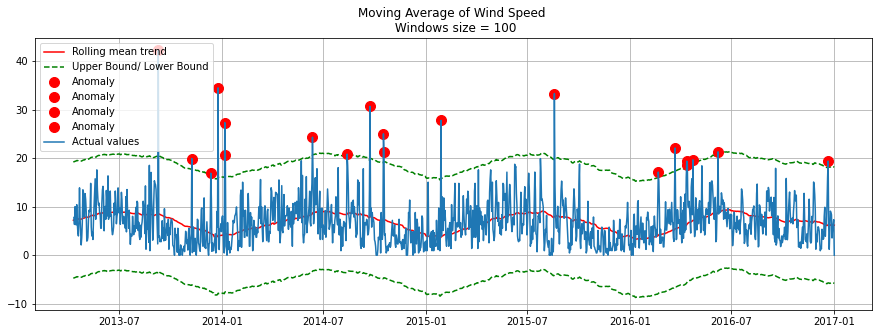

In [37]:
plot_moving_average(df.wind_speed, 100 ,'Wind Speed', plot_intervals=True, plot_anomalies=True)

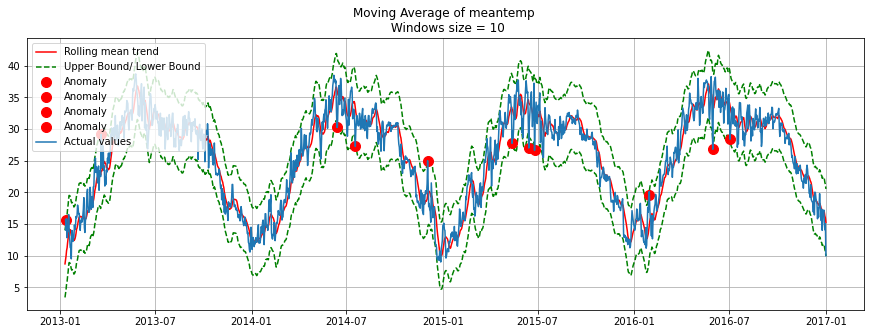

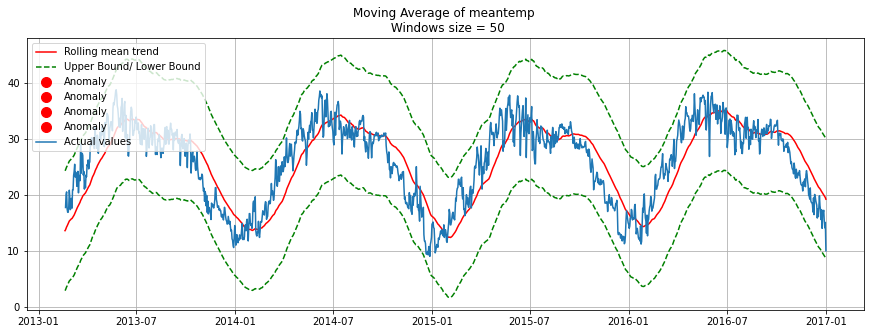

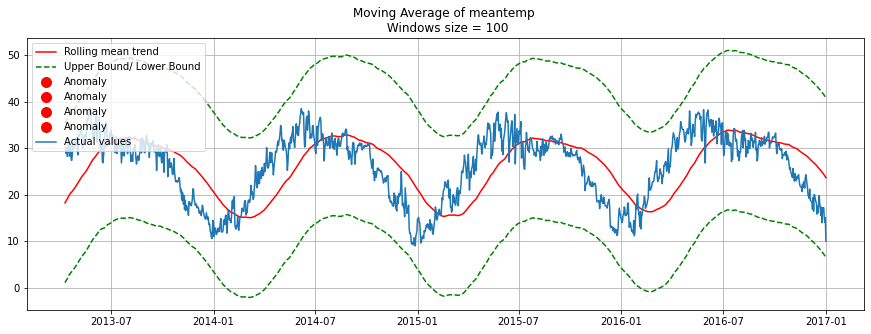

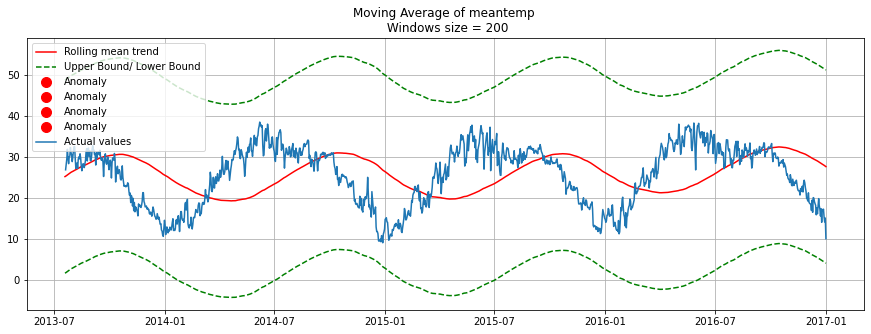

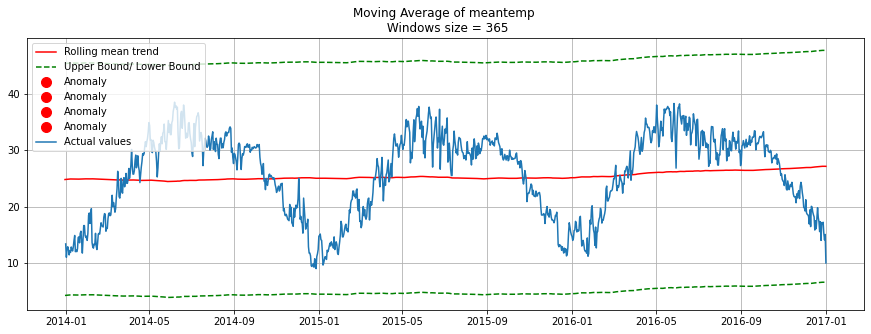

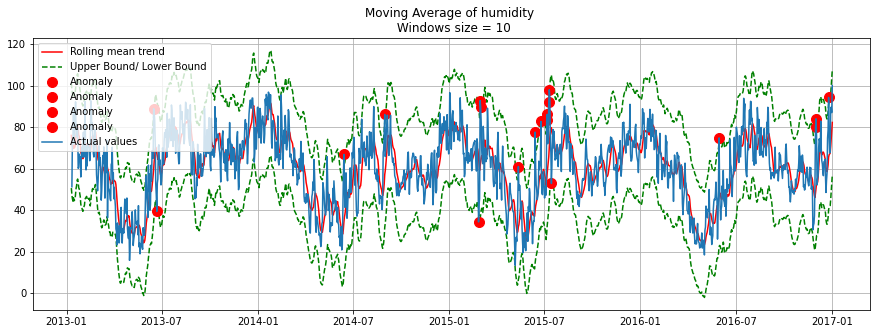

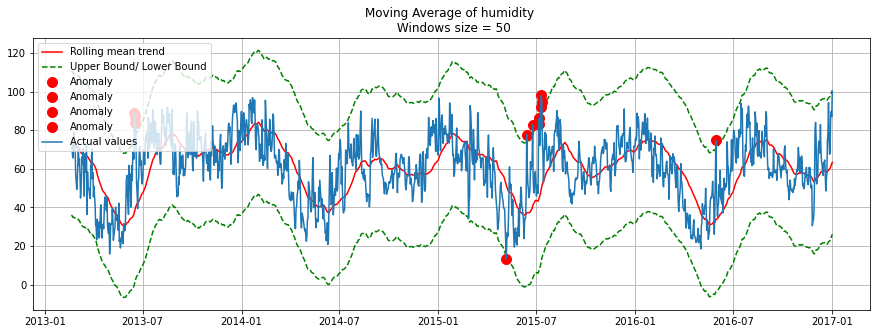

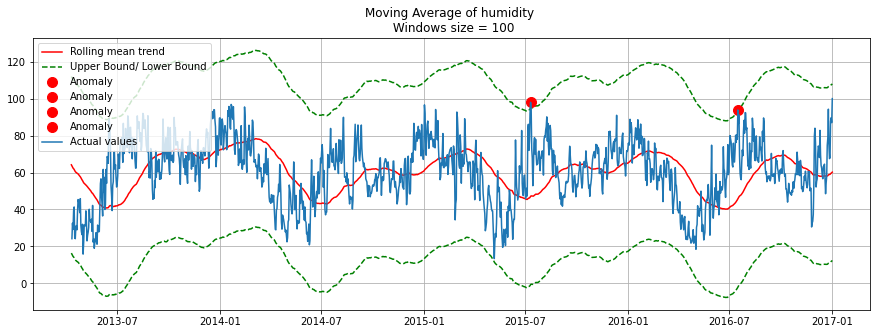

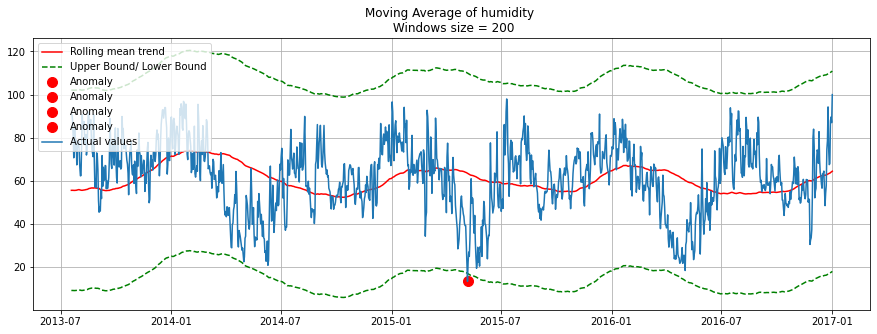

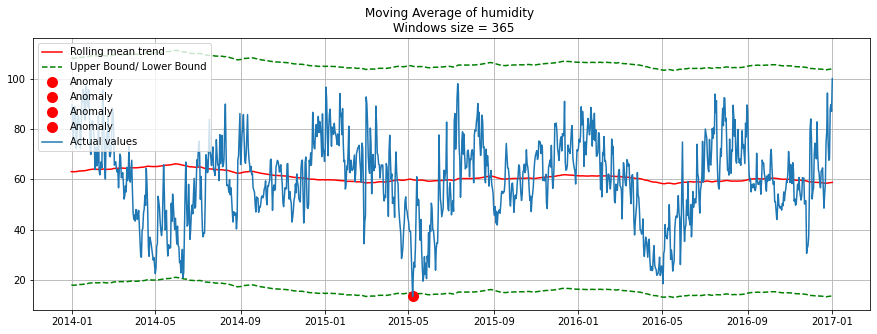

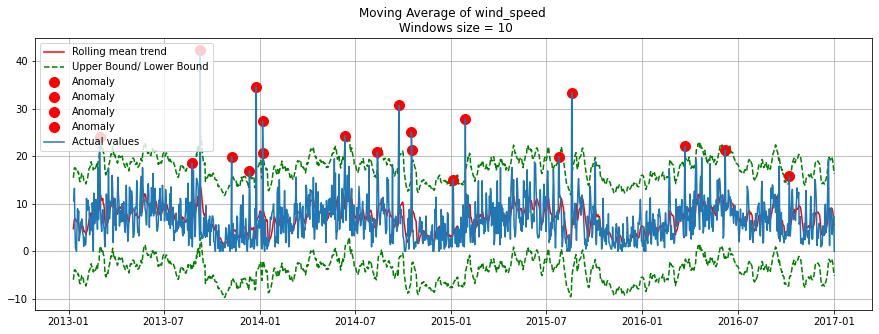

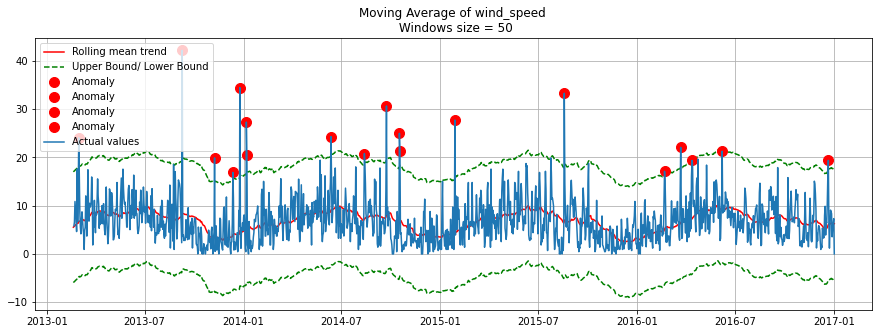

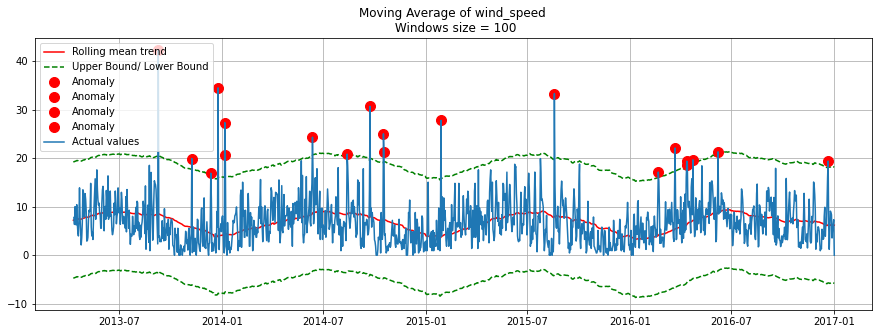

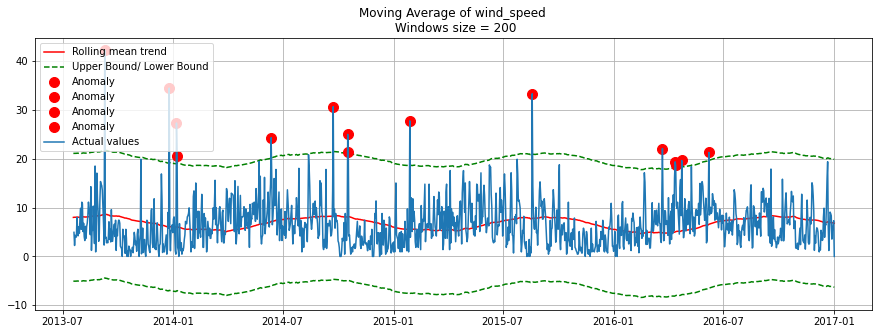

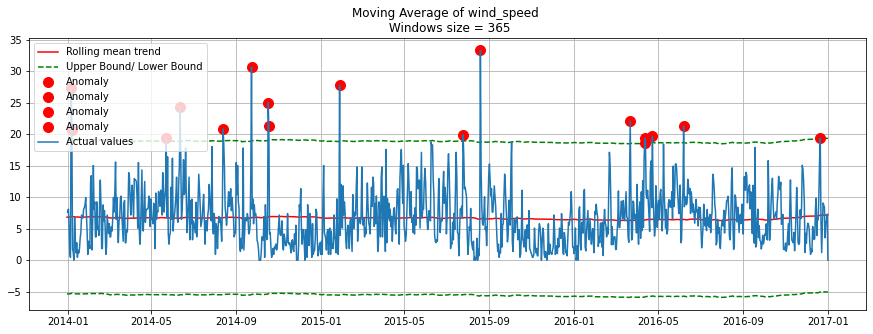

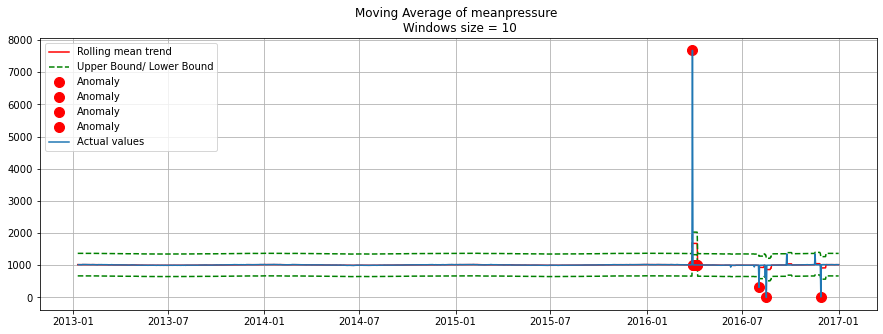

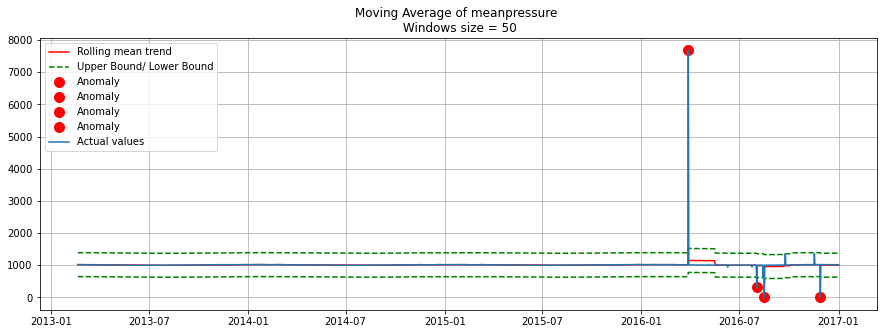

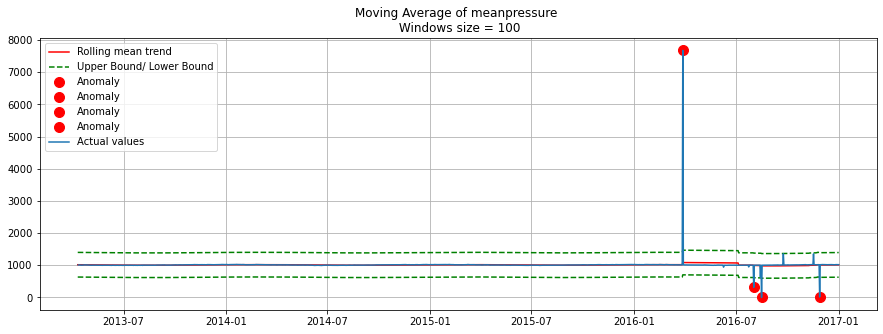

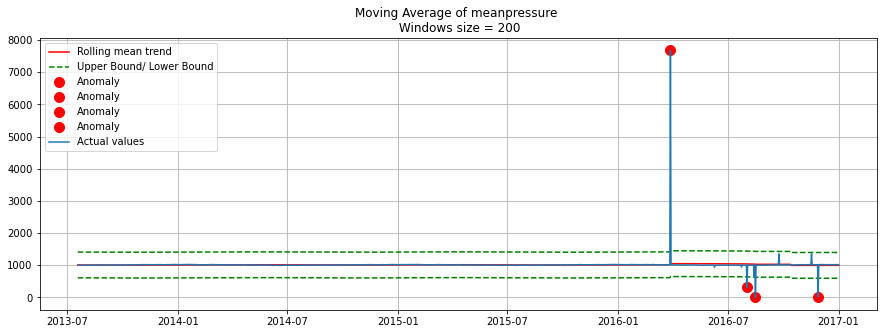

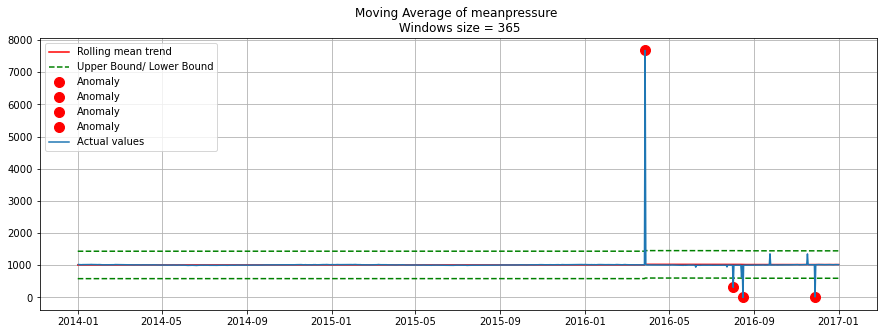

In [38]:
windows_size = [10,50,100,200,365]
for i in df.columns:
    for j in windows_size:
        plot_moving_average(df[i], j , i, plot_intervals=True, plot_anomalies=True)
plt.show()

##### Compare the different time series

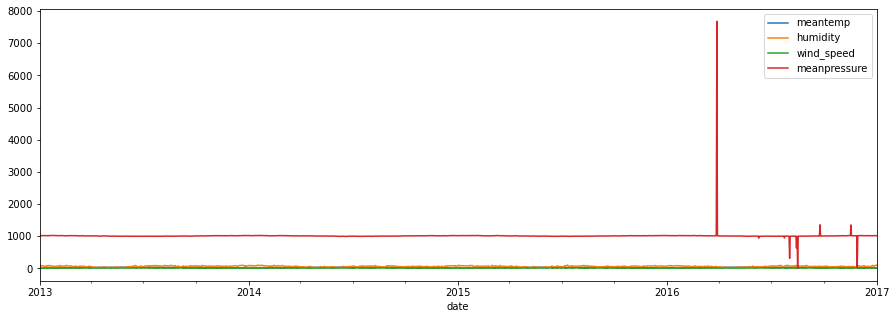

In [39]:
df.plot(figsize=(15,5))

Here we cannot derive any information from the figure, it is because all the datasets have their values in the different scale so we need to first convert them in the same unit so we will try to normalize them first and make a comparision

##### Normalization

In [40]:
df.wind_speed

date
2013-01-01    0.000000
2013-01-02    2.980000
2013-01-03    4.633333
2013-01-04    1.233333
2013-01-05    3.700000
                ...   
2016-12-28    3.547826
2016-12-29    6.000000
2016-12-30    6.266667
2016-12-31    7.325000
2017-01-01    0.000000
Freq: D, Name: wind_speed, Length: 1462, dtype: float32

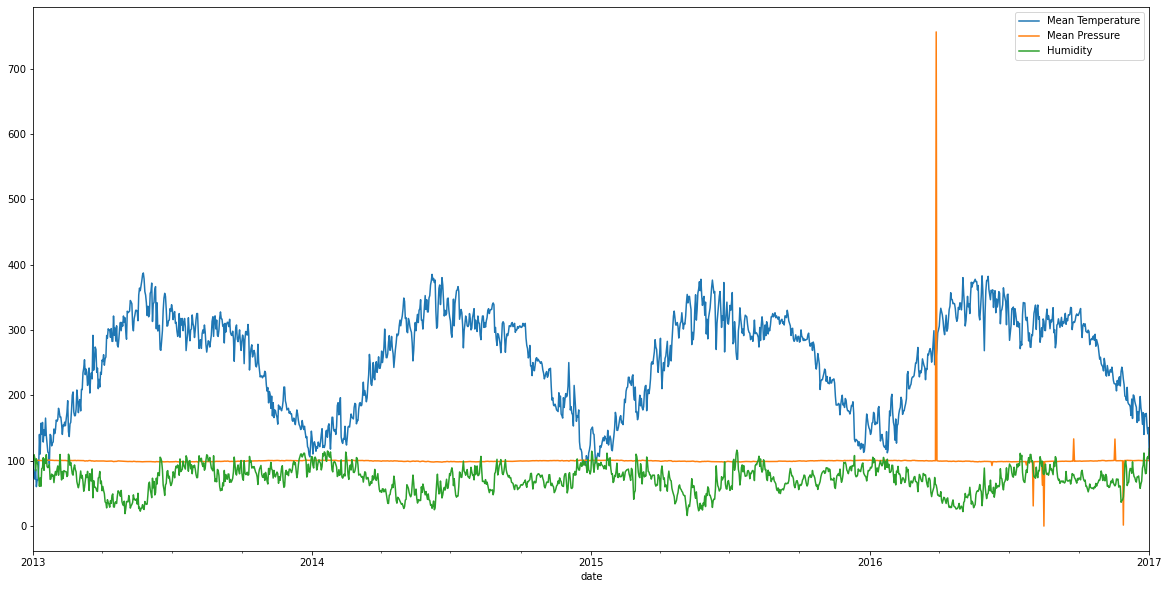

In [41]:
normalized_meantemp = df.meantemp.div(df.meantemp.iloc[0]).mul(100)
normalized_meanpressure = df.meanpressure.div(df.meanpressure.iloc[0]).mul(100)
normalized_humidity = df.humidity.div(df.humidity.iloc[0]).mul(100)

#plotting both th diagram
normalized_meantemp.plot(legend = True, figsize = (20,10))
normalized_meanpressure.plot(legend = True)
normalized_humidity.plot(legend = True)
plt.legend(['Mean Temperature', 'Mean Pressure','Humidity'])
plt.show()

Since wind_speed has the zero values so it is not compared by using this method. 

From the above figure we can see that how the humidity change with temperature and pressure is almost the same.

##### Augmented Dicky-Fuller Test
> An augmented Dickey-Fuller test (ADF) is done in order to test the presence of unit root in the dataset.It perform the hypothesis test. 
 - Null hypothsis (Ho) :- Unit root is present in the time series data(Non- stationary)
 - Alternative hypthesis (H1):- Unit root is absence in the time series dataset (Stationary)
 
> It tests the null hypothesis that a unit root is present in a time series sample. It is basically Dickey-Fully test with more lagged changes on RHS

##### Stationarity
> A stationary time series is one whose statistical properties such as mean, variance, autocorrelation are all constant over time.

> __Strong stationarity__ : is a stochastic process whose unconditional joint probability distribution does not change when shifted in time. Consequently, parameters such as mean and variance also do not change over time.

> __Weak stationarity__ : is a process where mean, variance, autocorrelation are constant throughtout the time.

> Stationarity is important as non-stationary series that depend on time have too many parameters to account for when modelling the time series. diff() method can easily convert a non-stationary series to a stationary series.

> In fact, the diff() describes the first derivative information of a time series，may be a stationary series.

> We will try to decompose seasonal component of the above decomposed time series.

> The red graph below is not stationary because the mean increases over time.
<img src="https://hsto.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png" alt="Alt text that describes the graphic" title="Title text" />


> We were unlucky with the variance and see the varying spread of values over time
<img src="https://hsto.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png" alt="Alt text that describes the graphic" title="Title text" />


> Finally, the covariance of the i th term and the (i + m) th term should not be a function of time. In the following graph, you will notice that the spread becomes closer as time increases. Hence, the covariance is not constant with time in the right chart.
<img src="https://hsto.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png" alt="Alt text that describes the graphic" title="Title text" />

> why is stationarity so important? 
 - It is easy to make predictions on a stationary series  as we know that the statistical properties will not be different from those currently observer so it is important.

> What if the data is not Stationary?
 - In that case we need to know about the white noise and a random walk. But for simplicity we can convert the non-stationary series to Stationary by performing the difference between the current and the last observation which is the main concept of Dicky-Fuller. Whereas in the Augmented Dicky-Fuller multiple lags are considered for converting the non-stationary to stationary series.  

##### Shifting and lags
> Let us see what is shift and lags with an example. we are going to shift the series by 12 month.

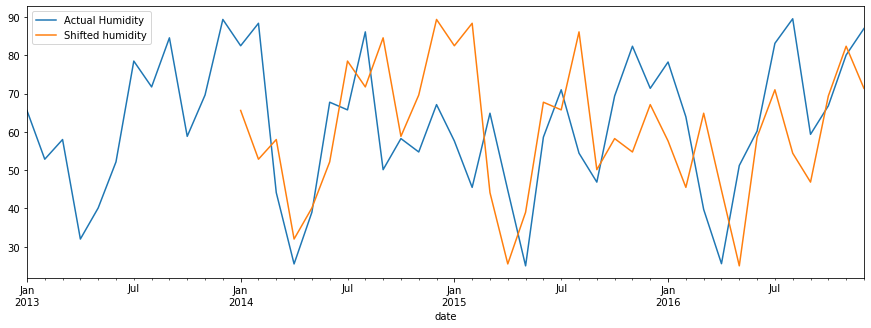

In [42]:
df['humidity'].asfreq('M').plot(legend = True, figsize = (15,5))
shifted = df['humidity'].asfreq('M').shift(12).plot(legend = True) #shifting humidy by 1 year i.e. data of 2013 jan is shifted to 2014 jan
shifted.legend(['Actual Humidity','Shifted humidity'])
plt.show()

##### ACF and PACF
   - __Autocorrelation__ : The autocorrelation function (ACF) measures how a series is correlated with itself at different lags

   - __Partial Autocorrelation__ : The partial autocorrelation function can be interpreted as a regression of the series against its past lags.The terms can be interpreted the same way as a standard linear regression, that is the contribution of a change in that particular lag while holding others constant.

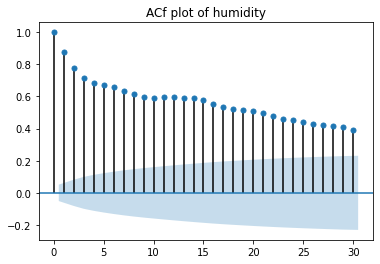

In [43]:
# example of acf
plot_acf(df.humidity, lags = 30, title = 'ACf plot of humidity')
plt.show()

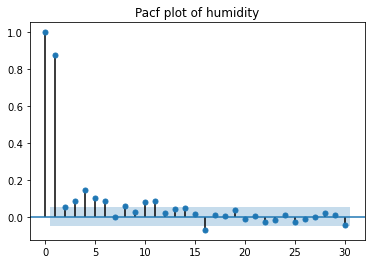

In [44]:
# examlpe of pacf
plot_pacf(df.humidity, lags = 30, title = 'Pacf plot of humidity')
plt.show()

Let us perform augmented Dicky-Fuller test for our dataset

In [45]:
def test_adfuller(series):
    result = adfuller(series)
    labels = ['adf value', 'p-value', '# lags', '# observation']
    out = pd.Series(result[:4], index=labels)
  
    for key,val in result[4].items():
        out['critical '+key]=val
    
    print(out)
    
    if(result[1] <= 0.5):
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [46]:
test_adfuller(df['meantemp'])

adf value          -2.021069
p-value             0.277412
# lags             10.000000
# observation    1451.000000
critical 1%        -3.434865
critical 5%        -2.863534
critical 10%       -2.567832
dtype: float64
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


## From here, We will be only taking the Mean Teamperature and work on it

In [47]:
df = pd.DataFrame(df.meantemp)

In [48]:
df

meantemp
date                 
2013-01-01  10.000000
2013-01-02   7.400000
2013-01-03   7.166667
2013-01-04   8.666667
2013-01-05   6.000000
...               ...
2016-12-28  17.217392
2016-12-29  15.238095
2016-12-30  14.095238
2016-12-31  15.052631
2017-01-01  10.000000

[1462 rows x 1 columns]

# Model Creation

##### First of all we need to plot the dataset and its ACF(auto correlation function) and PACF(partial auto correlation function)

In [49]:
# defining function to plot acf and pacf
def tsplot(series, lags = None, figsize = (15,10), style = 'bmh'):
    with plt.style.context(style):
        fig = plt.figure(figsize = figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout,(1,1))
        
        series.plot(ax=ts_ax)
        p_value = adfuller(df)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        
        plot_acf(series,ax=acf_ax)
        plot_pacf(series,ax = pacf_ax)
        plt.show()

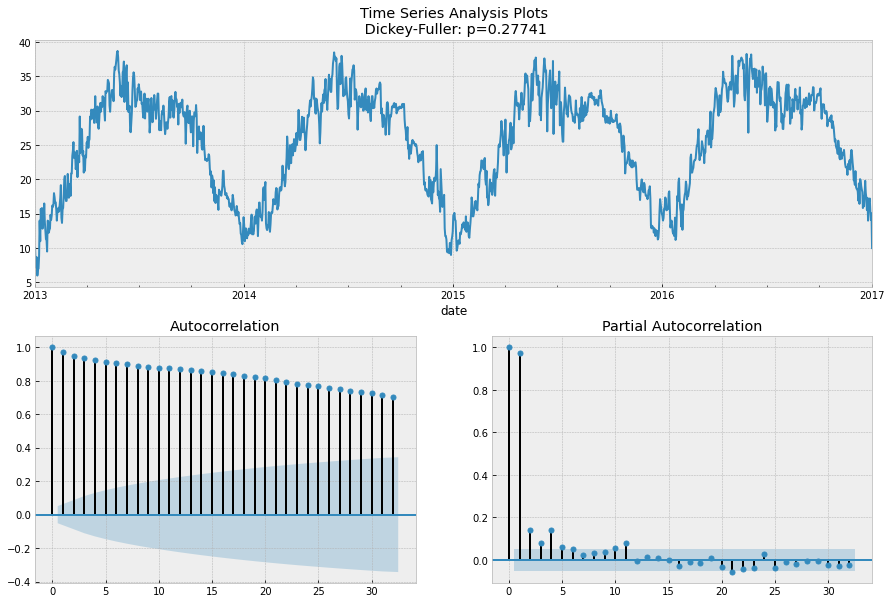

In [50]:
tsplot(df.meantemp, lags=50)

From the figure, visually, we can see that there is almost a constant mean and variance is also preety much constant.It is stationary but there exist a seasonality which needed to be removed by calculating the difference. In order to remove the seasonality we need to shift the series by a period of a year.

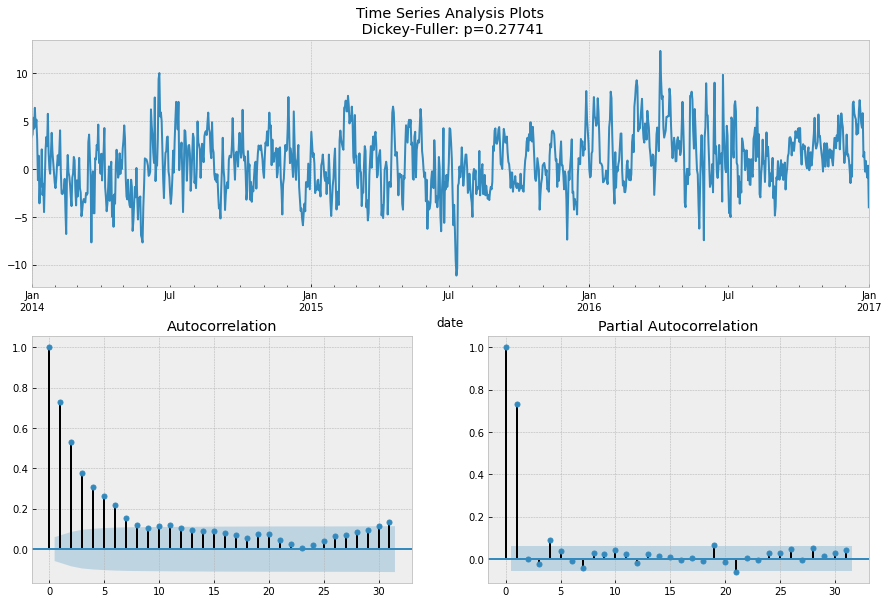

In [51]:
data_diff = df.meantemp-df.meantemp.shift(365)
tsplot(data_diff[365:], lags = 50)

As we can see from the figure that seasonality is removed. If we look at the pacf or partial Autocorrelation graph we can see that it decays immediatly so it is what we need. Looking on ACF graph we can see that  it takes longer to decay so it means that there are many significant lags so let's difference once more to removed such significance.

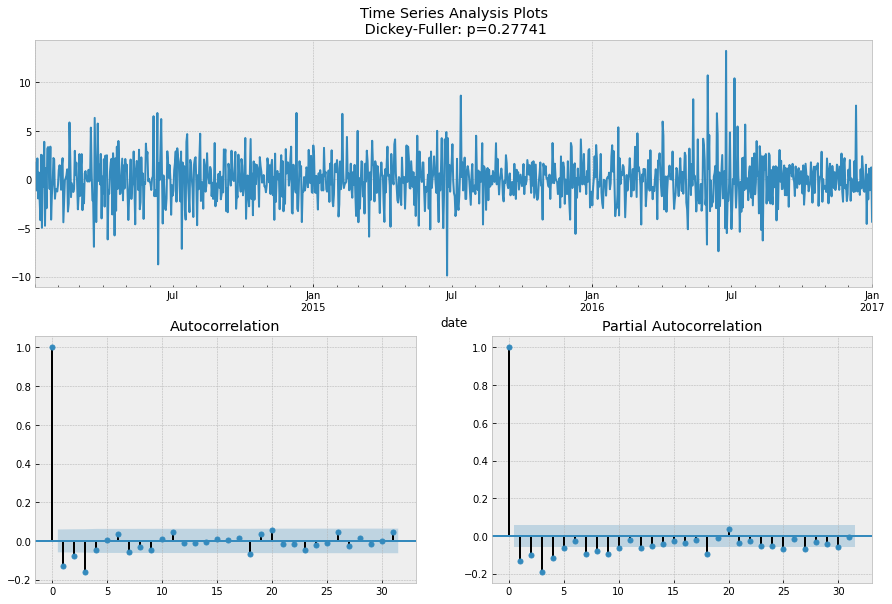

In [52]:
# shifting by 1
data_diff1 = data_diff-data_diff.shift(1)
tsplot(data_diff1[365+1:], lags = 50)

Here we can see that acf has lesser significance where as significant lags has increased in the pacf. 
What we can do is that, we can use AR model with the first difference and forecast the future and we can use 2nd difference and use model MA to predict the future.

###### We can see that our data consist of the seasonality so it is preety clear that we need to use SARIMA model. But for the practise and how other model predict we will try implementing AR, MA, ARMA, ARIMA model also. Which will be described as we go on.

##### AR model
> AR(p) model is an autoregression model i.e. regression of the time series onto itself. The basic assumption is that the   current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is   referred to as  p . To determine the initial  p , we need to look at the PACF plot and find the biggest significant lag after which most other lags become insignificant.

In [53]:
import statsmodels as smodel

In [54]:
%%time
res= smodel.tsa.arima_model.ARMA(df.meantemp, order=(1,0)).fit()

Wall time: 68.8 ms


In [55]:
# Print out summary information on the fit
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:               meantemp   No. Observations:                 1462
Model:                     ARMA(1, 0)   Log Likelihood               -2818.516
Method:                       css-mle   S.D. of innovations              1.662
Date:                Wed, 16 Dec 2020   AIC                           5643.032
Time:                        12:11:02   BIC                           5658.894
Sample:                    01-01-2013   HQIC                          5648.949
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             24.6684      1.796     13.734      0.000      21.148      28.189
ar.L1.meantemp     0.9763      0.006    167.133      0.000       0.965       0.988
                                    

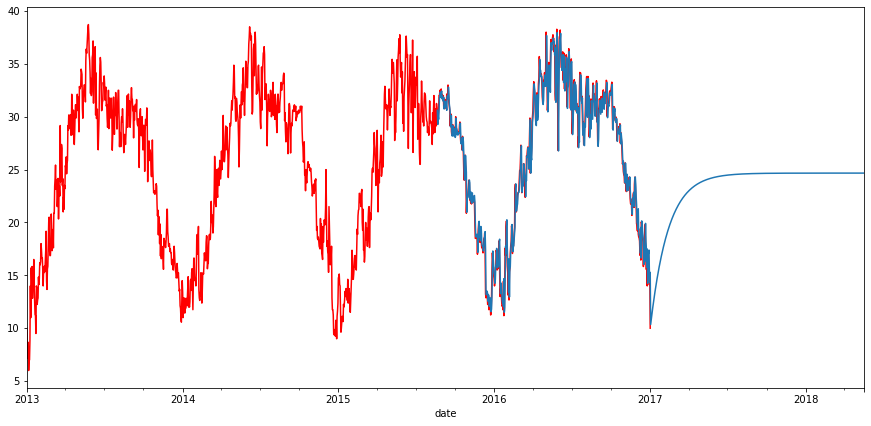

In [56]:
plt.figure(figsize= (15,7))
df.meantemp.plot(color = 'r')
res.predict(start=len(df.meantemp[:-500]), end=len(df.meantemp)+500).plot()

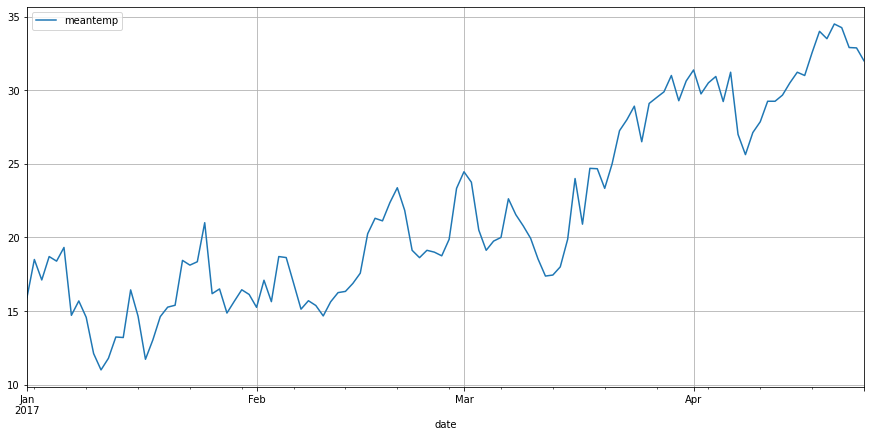

In [57]:
df_test = pd.read_csv('DailyDelhiClimateTest.csv', index_col = 'date', parse_dates=True)
df_test.meantemp.plot(figsize=(15,7), legend = True, grid = True)

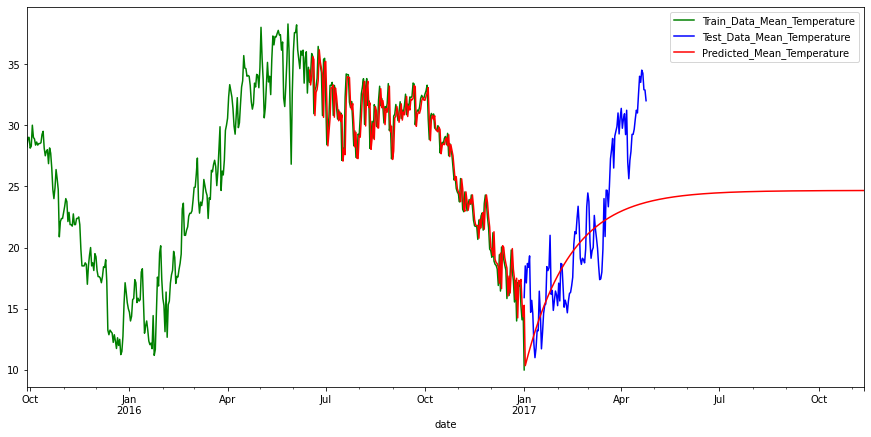

In [58]:
plt.figure(figsize= (15,7))
df.meantemp[1000:].plot(color = 'g')
df_test.meantemp.plot(color = 'b')
res.predict(start=len(df.meantemp[:-200]), end=len(df.meantemp)+len(df_test.meantemp)+200).plot(color = 'r')
plt.legend(['Train_Data_Mean_Temperature', 'Test_Data_Mean_Temperature' , 'Predicted_Mean_Temperature'])

We can see that AR model simple is not able to predict properly. So let us see how good we will obtain from the MA model

##### MA model
> MA(q) is a moving average model. Without going into too much detail, this models the error of the time series, again with the assumption that the current error depends on the previous with some lag, which is referred to as  q . The initial value can be found on the ACF plot with the same logic as before.

In [59]:
# from the second defference we can see there are 3 significant langs and rest are insignificant lags
res=smodel.tsa.arima_model.ARMA(df.meantemp, order=(0,1)).fit()

In [60]:
# Print out summary information on the fit
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:               meantemp   No. Observations:                 1462
Model:                     ARMA(0, 1)   Log Likelihood               -4231.514
Method:                       css-mle   S.D. of innovations              4.371
Date:                Wed, 16 Dec 2020   AIC                           8469.027
Time:                        12:11:02   BIC                           8484.890
Sample:                    01-01-2013   HQIC                          8474.944
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             25.4860      0.209    121.885      0.000      25.076      25.896
ma.L1.meantemp     0.8297      0.011     78.777      0.000       0.809       0.850
                                    

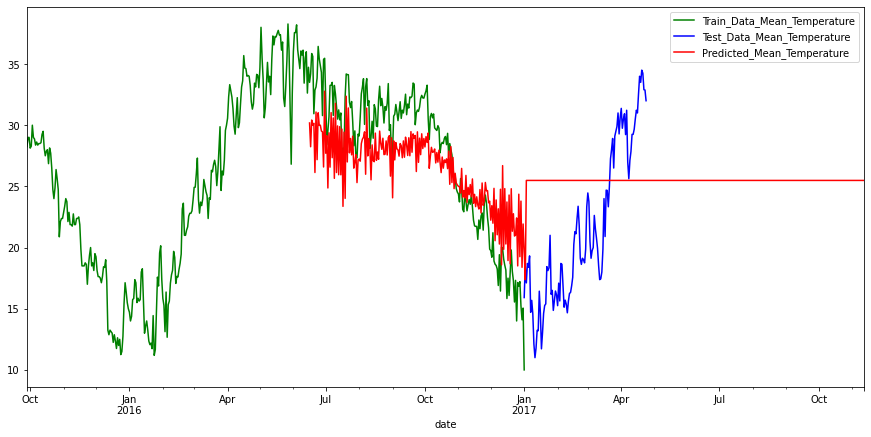

In [61]:
plt.figure(figsize= (15,7))
df.meantemp[1000:].plot(color = 'g')
df_test.meantemp.plot(color = 'b')
res.predict(start=len(df.meantemp[:-200]), end=len(df.meantemp)+len(df_test.meantemp)+200).plot(color = 'r')
plt.legend(['Train_Data_Mean_Temperature', 'Test_Data_Mean_Temperature' , 'Predicted_Mean_Temperature'])

We can see that is is even more worst than the AR model so Let us use both the model which is known as ARMA model

##### ARMA model
AR(p)+MA(q)=ARMA(p,q)

In [62]:
res=smodel.tsa.arima_model.ARMA(df.meantemp, order=(1,1)).fit()
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:               meantemp   No. Observations:                 1462
Model:                     ARMA(1, 1)   Log Likelihood               -2797.106
Method:                       css-mle   S.D. of innovations              1.638
Date:                Wed, 16 Dec 2020   AIC                           5602.211
Time:                        12:11:03   BIC                           5623.361
Sample:                    01-01-2013   HQIC                          5610.100
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             24.1438      2.387     10.116      0.000      19.466      28.822
ar.L1.meantemp     0.9862      0.005    209.587      0.000       0.977       0.995
ma.L1.meantemp    -0.2057      0.032

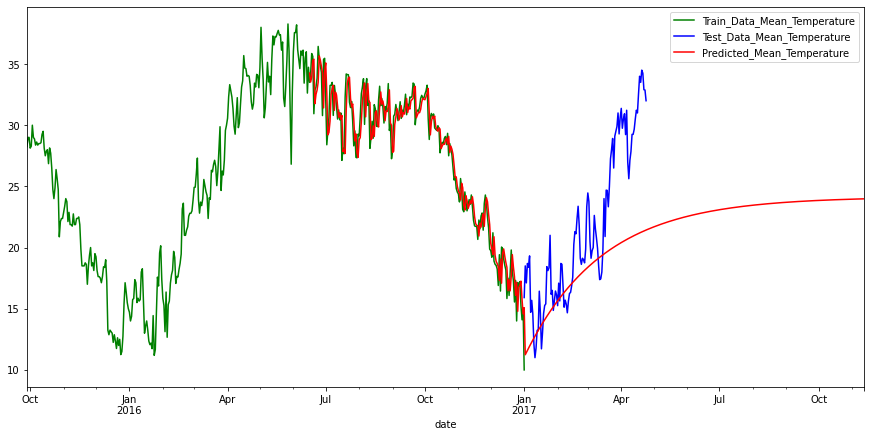

In [63]:
plt.figure(figsize= (15,7))
df.meantemp[1000:].plot(color = 'g')
df_test.meantemp.plot(color = 'b')
res.predict(start=len(df.meantemp[:-200]), end=len(df.meantemp)+len(df_test.meantemp)+200).plot(color = 'r')
plt.legend(['Train_Data_Mean_Temperature', 'Test_Data_Mean_Temperature' , 'Predicted_Mean_Temperature'])

##### ARIMA model

In [64]:
res=smodel.tsa.arima_model.ARIMA(df.meantemp, order=(5,2,1)).fit()
print(res.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.meantemp   No. Observations:                 1460
Model:                 ARIMA(5, 2, 1)   Log Likelihood               -2771.893
Method:                       css-mle   S.D. of innovations              1.611
Date:                Wed, 16 Dec 2020   AIC                           5559.785
Time:                        12:11:04   BIC                           5602.075
Sample:                    01-03-2013   HQIC                          5575.561
                         - 01-01-2017                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -8.425e-05   5.85e-05     -1.441      0.150      -0.000    3.04e-05
ar.L1.D2.meantemp    -0.2129      0.026     -8.113      0.000      -0.264      -0.161
ar.L2.D2.meantemp    -0.

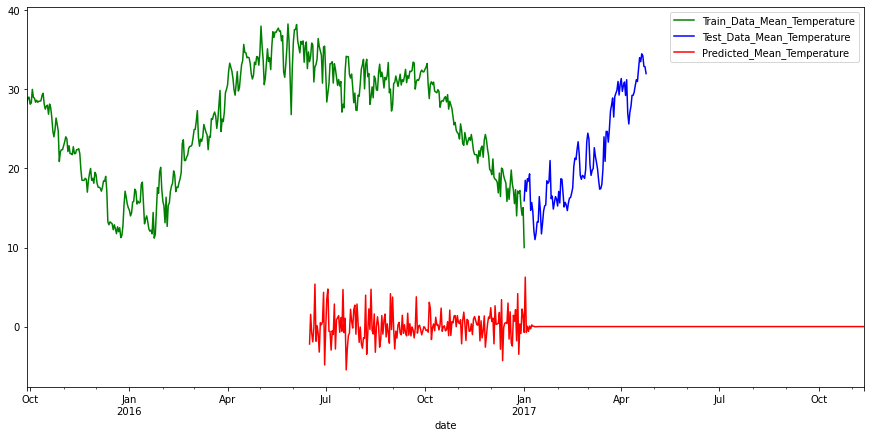

In [65]:
plt.figure(figsize= (15,7))
df.meantemp[1000:].plot(color = 'g')
df_test.meantemp.plot(color = 'b')
res.predict(start=len(df.meantemp[:-200]), end=len(df.meantemp)+len(df_test.meantemp)+200).plot(color = 'r')
plt.legend(['Train_Data_Mean_Temperature', 'Test_Data_Mean_Temperature' , 'Predicted_Mean_Temperature'])

##### SARIMA model

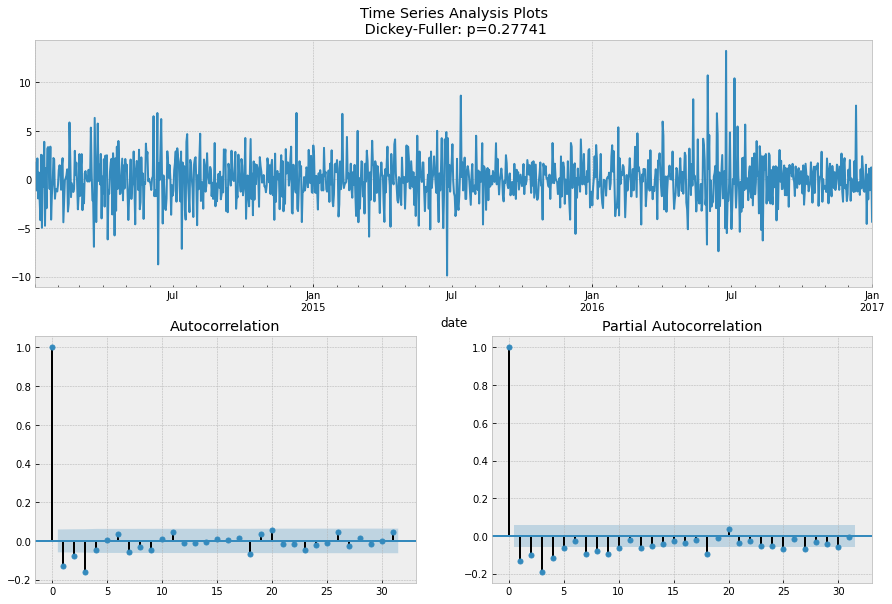

In [66]:
# shifting by 1
data_diff1 = data_diff-data_diff.shift(1)
tsplot(data_diff1[365+1:], lags = 50)

 - p  is most probably 8 since it is the last significant lag on the PACF, after which, most others are not significant.
 - d  equals 1 because we had first differences
 - q  should be somewhere around 3 as well as seen on the ACF
 - P  might be 1 or 2, we are unable to see the seasonality so we will range its value and predict
 - D  again equals 1 because we performed seasonal differentiation
 - Q  is probably 1 or 2,we are unable to see the seasonality so we will range its value and predict 

In [67]:
# setting initial values and some bounds for them
ps = 8
d=1 
qs = 5
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 365 # season length is still 365

# creating list with all the possible combinations of parameters
parameters = product(Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

4

In [68]:
#let us define the function to find the best SARIMA model with best parameter
def bestSARIMA(parameters_list, ps, qs, d, D, s):
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(df.meantemp, order=(ps, d, qs), 
                                            seasonal_order=(param[0], D, param[1], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [71]:
%%time
#result_table = bestSARIMA(parameters_list, ps, qs, d, D, s)

Wall time: 0 ns


In [72]:
#result_table.head()

In [ ]:
# set the parameters that give the lowest AIC
# p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df.meantemp, order=(8, 1, 5), 
                                        seasonal_order=(1, 1, 1, 365)).fit(disp=-1)
print(best_model.summary())

In [ ]:
#checking the residual of the model
tsplot(best_model.resid[24+1:], lags=60)

In [ ]:
def plotSARIMA(series, model, n_steps): #n_steps is the number of steps to be predict in the future
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

In [ ]:
plotSARIMA(df.meantemp, best_model, 100)

##### pmdarima
> Pmdarima (originally pyramid-arima, for the anagram of 'py' + 'arima') is a statistical library designed to fill the void in Python's time series analysis capabilities. like:-
 - The equivalent of R's auto.arima functionality
 - A collection of statistical tests of stationarity and seasonality
 - Time series utilities, such as differencing and inverse differencing
 - Numerous endogenous and exogenous transformers and featurizers, including Box-Cox and Fourier transformations
 - Seasonal time series decompositions
 - Cross-validation utilities
 - A rich collection of built-in time series datasets for prototyping and examples
 - Scikit-learn-esque pipelines to consolidate your estimators and promote productionization

In [ ]:
auto_arima(df['meantemp'], seasonal=False).summary()

In [ ]:
auto_arima(df['meantemp'], seasonal=True).summary()

# Model Validation

##### Predicting the test dataset

##### Cross Validation

##### Performance Measures

# Saving the model

##### pickle

##### joblib

##### parquet

##### Difference between pickle, joblib and parquet

# Loading the model and predicting the future